In [1]:
%%capture

%pip install 'qiskit'
%pip install 'qiskit-ionq>=0.15.2'
%pip install 'qbraid[visualization]>=0.9.3.dev20250127212255'

# Must restart the kernel after installing packages

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import phase_estimation

H = np.array(
    [
        [3, 0, 0, 0, 0, 0, 0, 0],
        [0, 3, 0, -1, 0, 0, 0, 0],
        [0, 0, 3, -1, 0, 0, 0, 0],
        [0, -1, -1, 2, 1, -1, 0, 0],
        [0, -1, -1, 1, 2, 1, 0, 0],
        [0, 0, 0, -1, 1, 2, 0, 0],
        [0, 0, 0, 0, 0, 0, 3, 0],
        [0, 0, 0, 0, 0, 0, 0, 3],
    ]
)

eigenvalues, eigenvectors = np.linalg.eig(H)
normalized_eigenvalues = np.exp(1j * np.angle(eigenvalues))
unitary_matrix = eigenvectors @ np.diag(normalized_eigenvalues) @ np.linalg.inv(eigenvectors)

num_qubits = int(np.log2(unitary_matrix.shape[0]))
u_cir = QuantumCircuit(num_qubits)
u_cir.unitary(unitary_matrix, list(range(num_qubits)), label="U")

num_evaluation_qubits = num_qubits
qpe = phase_estimation(num_evaluation_qubits, u_cir)

In [2]:
import qiskit
import qiskit_ionq

qiskit_provider = qiskit_ionq.IonQProvider()

backend = qiskit_provider.get_backend("simulator", gateset="native")

circuit = qiskit.transpile(qpe, backend=backend)

In [3]:
from qbraid.programs import load_program
from qbraid.runtime import QbraidProvider
from qbraid.transpiler.conversions.qiskit import qiskit_to_ionq

provider = QbraidProvider()

device = provider.get_device("ionq_simulator")

ionq_dict = qiskit_to_ionq(circuit, gateset="native")

program = load_program(ionq_dict)

run_input = program.serialize()

job = device.submit(run_input, shots=100, noise_model="aria-1")

In [4]:
job.status()

<INITIALIZING: 'job is being initialized'>

In [5]:
job.wait_for_final_state()

result = job.result()

In [6]:
counts = result.data.get_counts(decimal=True)

print(f"Counts: {counts}")

Counts: {0: 91, 1: 2, 2: 1, 3: 3, 4: 1, 5: 2}


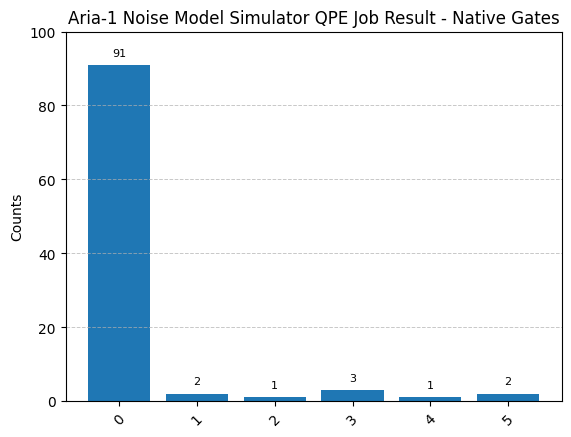

In [7]:
from qbraid.visualization import plot_histogram

plot_histogram(counts, title="Aria-1 Noise Model Simulator QPE Job Result - Native Gates")